# Advanced_Lane_Finding

In [1]:
import os 
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline

## Distortion Correction

In [2]:
def cam_cal(calibration_folder, nx, ny):
    '''
    Use chessboard images to obtain image points and object points
    '''
    try:
        dist_pickle = pickle.load(open(calibration_folder+'/calibration_pickle.p','rb'))
        mtx = dist_pickle['mtx']
        dist = dist_pickle['dist']
        print('calibration data loaded')
        return mtx,dist
    except FileNotFoundError:
        print("can not find the file, calculate now and save")
        # Arrays to store object points and image points from all the images
        objpoints = [] # 3D points in real word space
        imgpoints = [] # 2d points in image plane

        # Prepare object points, like (0,0,0), (1,0,0), (2,0,0)..., (nx,ny,0)
        objp = np.zeros((ny*nx,3), np.float32)
        objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape([-1,2]) # x, y coordinates


        # Read in and Make a list of calibration images
        images = glob.glob(calibration_folder+'/*.jpg')

        for fname in images:
            img = mpimg.imread(fname)
            # Convert to grayscale
            gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)

            # Find the chessboard corners
            ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

            # If found, add to imgpoints and objpoints
            if ret == True:
                imgpoints.append(corners)
                objpoints.append(objp)
        img = mpimg.imread(images[0])
        img_size = (img.shape[1],img.shape[0])
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

        dist_pickle = {}
        dist_pickle['mtx'] = mtx
        dist_pickle['dist'] = dist
        pickle.dump(dist_pickle,open(calibration_folder+'/calibration_pickle.p','wb'))
        return mtx, dist

## Color and Gradient Threshold

### Gradient Threshold

In [3]:
def abs_sobel_thresh(img, orient='x', thresh=(0,255)):
    '''
    Identify pixels where the gradient of an image falls within a specified threshold range.
    '''
    
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(img, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(img, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(img)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return binary_output

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    '''
    Calculate the magnitude of the gradient
    for a given sobel kernel size and threshold values
    '''
    
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(img)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

def dir_threshold(img, sobel_kernel=3, dir_thresh=(0, np.pi/2)):
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(img)
    binary_output[(absgraddir >= dir_thresh[0]) & (absgraddir <= dir_thresh[1])] = 1

    # Return the binary image
    return binary_output

### Color Threshold

In [4]:
def color_select(img,color_space,color_channel,thresh=(0, 255)):
    if color_space == 'RGB':
        channel = img[:,:,color_space.index(color_channel)]
    else:
        space = eval('cv2.cvtColor(img, cv2.COLOR_RGB2%s)'%color_space)
        channel = space[:,:,color_space.index(color_channel)]
    binary_output = np.zeros_like(channel)
    binary_output[(channel > thresh[0]) & (channel <= thresh[1])] = 1
    return binary_output

## Perspective Transform

In [5]:
def getM_Minv(img_size,bot_width,mid_width,height_pct,offset,bottom_trim):
    # 
    src = np.float32([[img_size[0]*(0.5-mid_width/2),img_size[1]*height_pct],  # top left
                      [img_size[0]*(0.5+mid_width/2),img_size[1]*height_pct],  # top right
                      [img_size[0]*(0.5+bot_width/2),img_size[1]*bottom_trim], # bottom right
                      [img_size[0]*(0.5-bot_width/2),img_size[1]*bottom_trim]])# bottom left
    dst = np.float32([[offset, 0],                       # top left
                      [img_size[0]-offset, 0],           # top right
                      [img_size[0]-offset, img_size[1]], # bottom right
                      [offset, img_size[1]]])            # bottom left
    M = cv2.getPerspectiveTransform(src,dst)
    Minv = cv2.getPerspectiveTransform(dst,src)
    return M,Minv

## Locate the Lane Lines and Fit a Polynomial

In [6]:
class Line():
    '''
    receive the characteristics of each line detection
    '''
    def __init__(self, ym=25/580, xm=3.7/590):
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        # average x values of the fitted line over the last n iterations
        self.bestx = None     
        # polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        # polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        # radius of curvature of the line in some units
        self.radius_of_curvature = None 
        # distance in meters of vehicle center from the line
        self.line_base_pos = None 
        # difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        # x values for detected line pixels
        self.allx = None  
        # y values for detected line pixels
        self.ally = None
        
        # meters per pixel in vertical/horizontal axis
        self.ym_per_pix = ym
        self.xm_per_pix = xm
        
    def fit(self,allx,ally):
        self.allx = allx
        self.ally = ally
        self.current_fit =  np.polyfit(self.ally, self.allx, 2)

        self.cal_radius_of_curvature()
        if self.best_fit is None:
            self.best_fit = self.current_fit
            self.pass_check()
        self.diffs = self.current_fit - self.best_fit
        
    def pass_check(self):
        self.best_fit = self.best_fit*0.2+self.current_fit*0.8
        
        image_size = (1280,720)
        yvals = range(0,720)
 
        current_xfitted=self.best_fit[0]*yvals*yvals + self.best_fit[1]*yvals+self.best_fit[2]
        self.recent_xfitted.append(np.array(current_xfitted,np.int32))
    
        self.bestx = np.average(self.recent_xfitted[-2:], axis=0)

        self.line_base_pos = (image_size[0]/2-self.bestx[-1])*self.xm_per_pix
    
    def cal_radius_of_curvature(self):
        yvals = range(0,720)
        curve_fit = np.polyfit(self.ally*self.ym_per_pix,self.allx*self.xm_per_pix,2)
        self.radius_of_curvature = ((1+(2*curve_fit[0]*yvals[-1]*self.ym_per_pix+curve_fit[1])**2)**1.5)/np.absolute(2*curve_fit[0])
    

In [7]:
from collections import deque
class Tracker(object):
    """
    tracker for the lines
    """
    def __init__(self, left_line, right_line, window_height, margin, minpix=50, minpoint=100, linewidth=590, mincurve=100):
        # instance of left line and right line
        self.left_line = left_line
        self.right_line = right_line
        
        # was the line detected in the last iteration?
        self.detected = deque([0]*5,maxlen=5)  
        
        # list that stores all the past (left,right) center set values used for smoothing the output
        self.recent_centers = []
        # window pixel height of the center values, used to count pixels
        # break the image into vertical levels
        self.window_height = window_height
        # Set the width of the windows +/- margin
        self.margin = margin
        # Set minimum number of pixels found to recenter window
        self.minpix = minpix
        # Set minimum number of point found to fit line
        self.min_point = minpoint
        # default line width , will be modified when detected two lines
        self.line_width = linewidth
        
        self.min_curve = mincurve
        
        
    def track_lines(self,warped,undist):
        if sum(self.detected)==0:
            out_img = self.find_lines(warped)
        else:
            out_img = self.find_lines_without_sliding_window(warped)
            
        return self.map_lane(undist,out_img)
    
    
    def find_lines(self,warped):
        window_height = self.window_height
        margin = self.margin
        minpix = self.minpix
        
        image_size = (warped.shape[1],warped.shape[0])
        
        # Take a histogram of the bottom half of the image
        histogram = np.sum(warped[image_size[1]//2:,:], axis=0)
        
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]//2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint
        
        # calculate the number of sliding windows
        nwindows = image_size[1] // self.window_height

        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base

        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []

        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = image_size[1] - (window+1)*window_height
            win_y_high = image_size[1] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
            
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)

        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds] 
        
        # Fit each line
        self.fit(leftx,lefty,rightx,righty)
        self.detected.append(1)
        
        # Create an output image to draw on and  visualize the result
        out_img = np.dstack((warped, warped, warped))*255
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        return out_img

    def find_lines_without_sliding_window(self,warped):
        
        left_fit = self.left_line.best_fit
        right_fit = self.right_line.best_fit
        
        nonzero = warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        margin = self.margin
        left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
        left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
        left_fit[1]*nonzeroy + left_fit[2] + margin))) 

        right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
        right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
        right_fit[1]*nonzeroy + right_fit[2] + margin)))  
        
        
        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds] 
              
        # Fit each line
        self.fit(leftx,lefty,rightx,righty)
        
        # Create an output image to draw on and  visualize the result
        out_img = np.dstack((warped, warped, warped))*255
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        return out_img
        
    def fit(self,leftx,lefty,rightx,righty):
        if len(leftx) > self.min_point and len(rightx) > self.min_point:
            self.left_line.fit(leftx,lefty)
            self.right_line.fit(rightx,righty)
        elif len(leftx) > self.min_point:
            self.left_line.fit(leftx,lefty)
        elif len(rightx) > self.min_point:
            self.right_line.fit(rightx,righty)
        else:
            self.detected.append(0)
            return
        yvals = range(0,720)
        left_current_xfitted=self.left_line.current_fit[0]*yvals*yvals + self.left_line.current_fit[1]*yvals+self.left_line.current_fit[2]
        right_current_xfitted=self.right_line.current_fit[0]*yvals*yvals + self.right_line.current_fit[1]*yvals+self.right_line.current_fit[2]
          
        if min(self.left_line.radius_of_curvature,self.right_line.radius_of_curvature) > self.min_curve and \
           max(right_current_xfitted-left_current_xfitted)<self.line_width*1.2 and \
           min(right_current_xfitted-left_current_xfitted)>self.line_width*0.8:
            self.left_line.pass_check()
            self.right_line.pass_check()
            
            self.detected.append(1)
        else:
            self.detected.append(0)
        
    

    def cal_offset(self):
        center_diff = (self.right_line.line_base_pos+self.left_line.line_base_pos)/2
        side_pos = 'right' if center_diff >=0 else 'left'
        return center_diff,side_pos
    
    def measure_curvature_real(self):
        return (self.left_line.radius_of_curvature,self.right_line.radius_of_curvature)
        
    
    def map_lane(self,undist,out_img):
        image_size = (undist.shape[1],undist.shape[0])

        # x and y values for plotting
        ploty = np.linspace(0, image_size[1]-1, image_size[1])

        left_fitx = self.left_line.bestx
        right_fitx = self.right_line.bestx
        
        # Create an image to draw the lines on
        warp_zero = np.zeros_like(undist[:,:,0]).astype(np.uint8)
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
        
        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        pts = np.hstack((pts_left, pts_right))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        newwarp = cv2.warpPerspective(color_warp, Minv, img_size) 
        
        # Create an image to draw the lines on
        warp_zero = np.zeros_like(undist[:,:,0]).astype(np.uint8)
        road_warp = np.dstack((warp_zero, warp_zero, warp_zero))
        road_warp_bkg = np.dstack((warp_zero, warp_zero, warp_zero))
        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([left_fitx-5, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([left_fitx+5, ploty])))])
        pts_left_line = np.hstack((pts_left, pts_right))
        
        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([right_fitx-5, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx+5, ploty])))])
        pts_right_line = np.hstack((pts_left, pts_right))
        
        # Draw the line onto the warped blank image
        cv2.fillPoly(road_warp, np.int_([pts_left_line]), (255,0, 0))
        cv2.fillPoly(road_warp, np.int_([pts_right_line]), (0,0,255))
        cv2.fillPoly(road_warp_bkg, np.int_([pts_left_line]), (255,255, 255))
        cv2.fillPoly(road_warp_bkg, np.int_([pts_right_line]), (255,255, 255))
        
        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        new_line_warp = cv2.warpPerspective(road_warp, Minv, img_size) 
        new_line_warp_bkg = cv2.warpPerspective(road_warp_bkg, Minv, img_size) 
        
        # Combine the result with the original image
        result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
        result = cv2.addWeighted(result, 1, new_line_warp_bkg, -1, 0)
        result = cv2.addWeighted(result, 1, new_line_warp, 1, 0)
        out = cv2.addWeighted(out_img, 1, road_warp_bkg, -1, 0)
        out = cv2.addWeighted(out, 1, road_warp, 1, 0)
        out = cv2.resize(out,None,fx=0.3,fy=0.3)
        result[:216,-384:] = out
        return result
        

## Pipeline 

In [8]:
def warp_thresh_image(undist):
    warped = cv2.warpPerspective(undist,M,img_size,flags=cv2.INTER_LINEAR)

    # color threshold 
    r_rgb = color_select(warped, 'RGB', 'R', (225,255))
    b_lab = color_select(warped, 'LAB', 'B', (150,255))
    l_luv = color_select(warped, 'LUV', 'L', (212,255))
    
    combined = np.zeros_like(warped[:,:,0])
    combined[(b_lab==1)|(l_luv==1)|(r_rgb==1)]=1
    
    return combined

def process_image(img,tracker):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    combined = warp_thresh_image(undist)
    
    # track the lane
    result = tracker.track_lines(combined,undist)

    curverad_left,curverad_right = tracker.measure_curvature_real()
    curverad = (curverad_left+curverad_right)/2
    center_diff,side_pos = tracker.cal_offset()

    cv2.putText(result,
                'Radius of Curvature = %s m'% (round(curverad) if curverad<1200 else 'inf'),
                (50,50),cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),2)
    cv2.putText(result,
                'Vehicle is %.2f m %s of center'%(abs(center_diff),side_pos),
                (50,100),cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),2)
    return result

In [9]:
nx = 9 # the number of inside corners in x
ny = 6 # the number of inside corners in y

# folder contain images for Distortion Correction
calibration_folder = 'camera_cal'
mtx, dist = cam_cal(calibration_folder, nx, ny)
# read in image
img = mpimg.imread('test_images/test5.jpg')
# work on defining perspective transformation area
img_size = (img.shape[1],img.shape[0])
offset = img_size[0]*.2
bot_width = 0.9    # percent of bootom trapizoid height 0.76 0.62        0.9
mid_width = 0.125    # percent of middle trapizoid height 0.08 0.043
height_pct = 0.64   # percent for trapizoid height 0.62 0.61
bottom_trim = 1 # percent from top to bottom to avoid car hood 0.935     1

M, Minv = getM_Minv(img_size,bot_width,mid_width,height_pct,offset,bottom_trim)

# window settings
window_height = 80 # Break image into 9 vertical layers since image height is 720
margin = 100 # How much to slide left and right for searching

calibration data loaded


### On test image

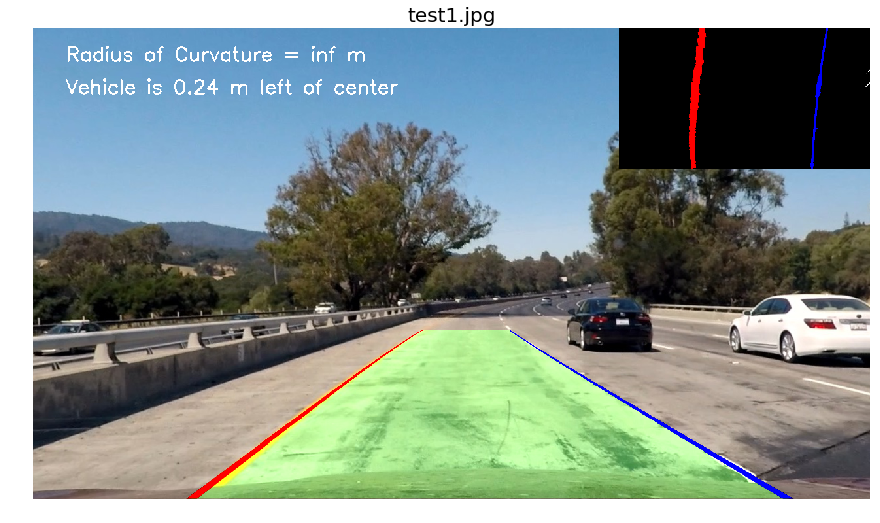

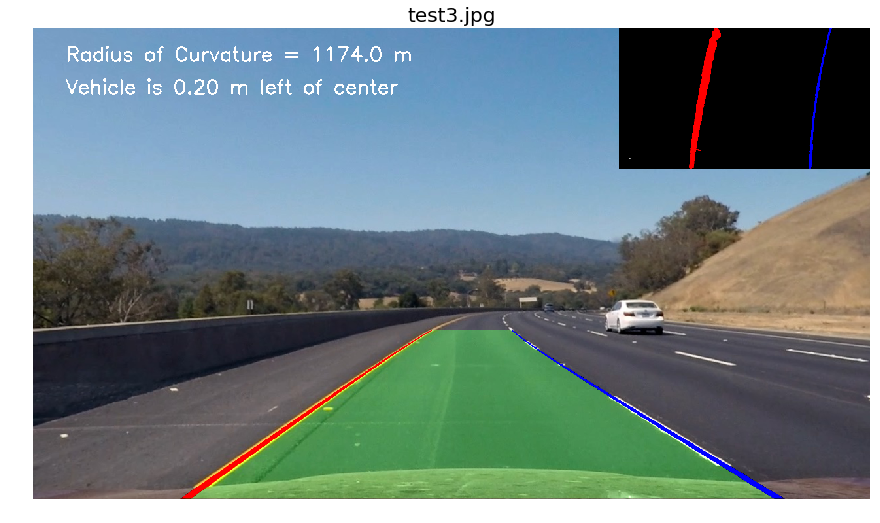

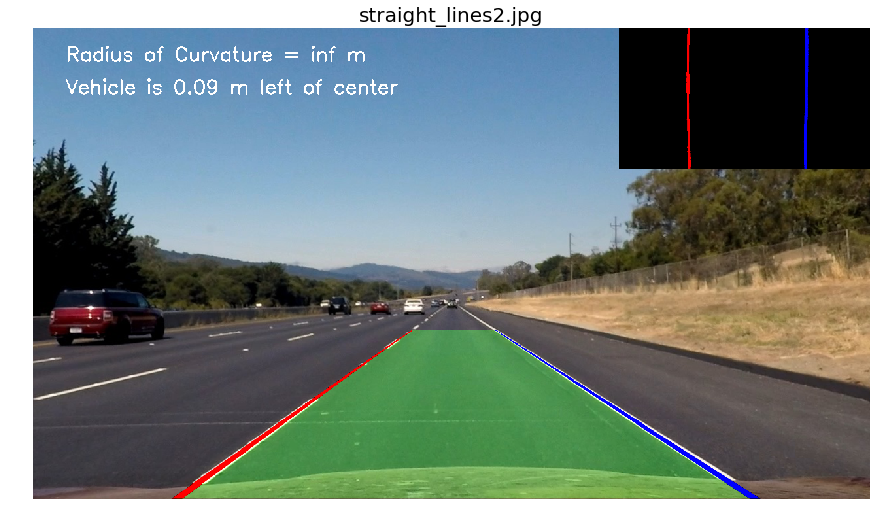

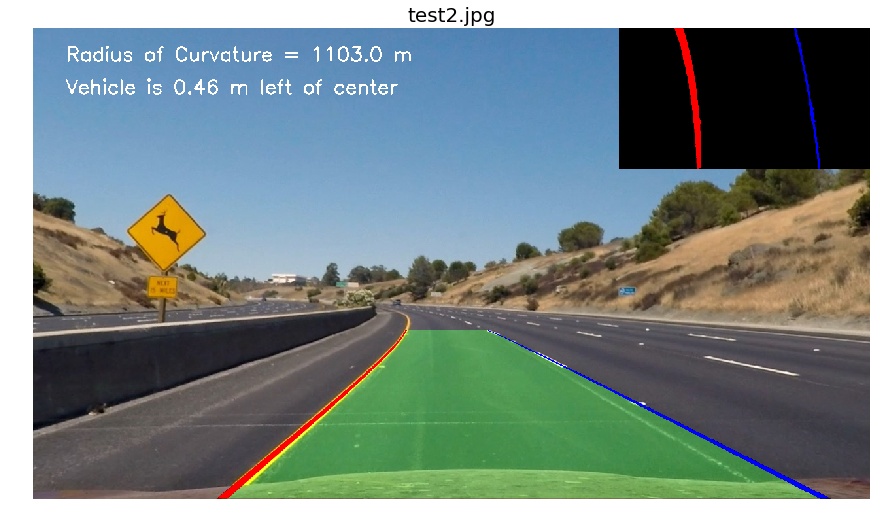

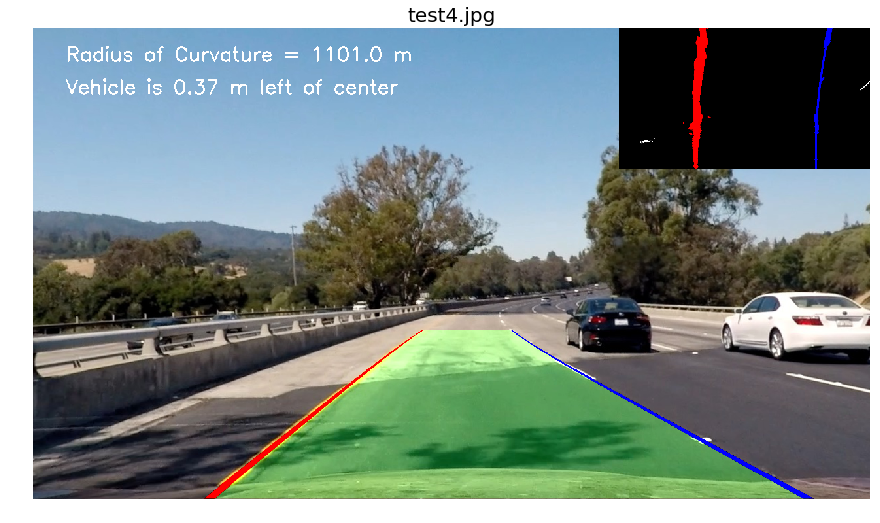

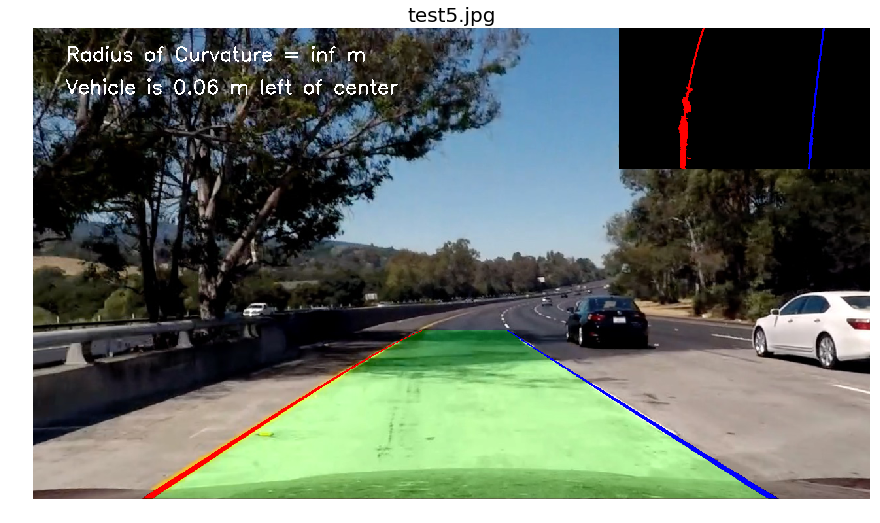

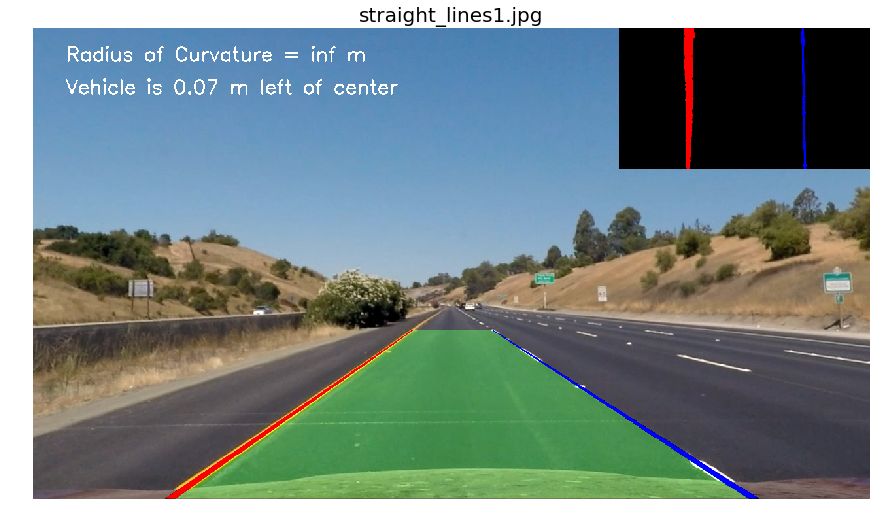

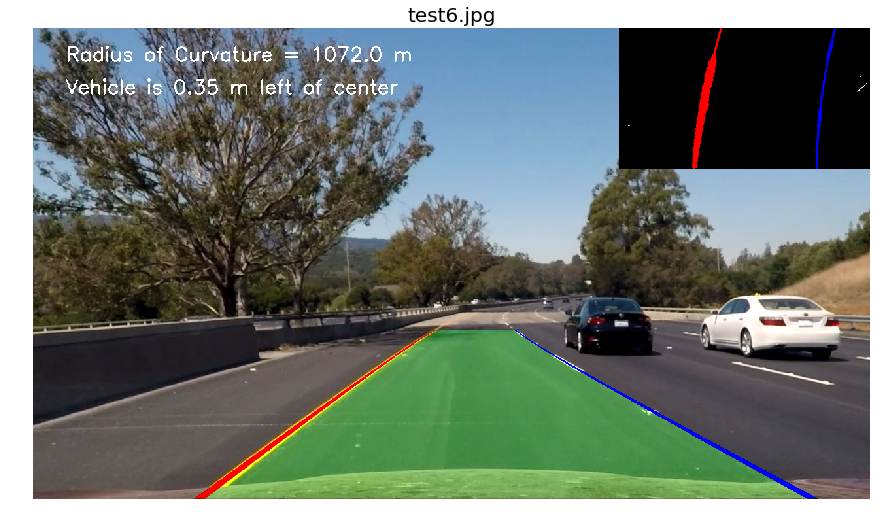

In [10]:
images = glob.glob('test_images/*.jpg')
for fname in images:
    img = mpimg.imread(fname)
    
    left_line = Line()
    right_line = Line()
    tracker = Tracker(left_line,right_line,window_height, margin)
    result = process_image(img,tracker)
    
    
    plt.figure(figsize=(15,9))
    plt.imshow(result)
    plt.axis('off')
    plt.title(os.path.basename(fname),fontsize=20)
    plt.show()

### on videos

#### on project video

In [11]:
left_line = Line()
right_line = Line()
tracker = Tracker(left_line,right_line,window_height, margin)

project_video_output = 'output_videos/project_video_output.mp4'
if not os.path.exists('output_videos'):
    os.mkdir('output_videos')
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
project_video_clip = clip1.fl_image(lambda image: process_image(image,tracker)) #NOTE: this function expects color images!!
%time project_video_clip.write_videofile(project_video_output, audio=False)

[MoviePy] >>>> Building video output_videos/project_video_output.mp4
[MoviePy] Writing video output_videos/project_video_output.mp4


100%|█████████▉| 1260/1261 [01:57<00:00, 10.74it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/project_video_output.mp4 

CPU times: user 4min 45s, sys: 1min 26s, total: 6min 11s
Wall time: 1min 58s


In [12]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_video_output))

#### on challenge video

In [13]:
# work on defining perspective transformation area
img_size = (img.shape[1],img.shape[0])
offset = img_size[0]*.2
bot_width = 0.9    # percent of bootom trapizoid height 0.76 0.62        0.9
mid_width = 0.255    # percent of middle trapizoid height 0.08 0.043
height_pct = 0.7  # percent for trapizoid height 0.62 0.61
bottom_trim = 1 # percent from top to bottom to avoid car hood 0.935     1

M, Minv = getM_Minv(img_size,bot_width,mid_width,height_pct,offset,bottom_trim)

In [14]:
left_line = Line(ym=10/590,xm=3.7/590)
right_line = Line(ym=10/590, xm=3.7/590)
tracker = Tracker(left_line, right_line, window_height, margin,minpoint=50,linewidth=480)

challenge_video_output = 'output_videos/challenge_video_output.mp4'
if not os.path.exists('output_videos'):
    os.mkdir('output_videos')
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("challenge_video.mp4")
challenge_video_clip = clip1.fl_image(lambda image: process_image(image,tracker)) #NOTE: this function expects color images!!
%time challenge_video_clip.write_videofile(challenge_video_output, audio=False)

[MoviePy] >>>> Building video output_videos/challenge_video_output.mp4
[MoviePy] Writing video output_videos/challenge_video_output.mp4


100%|██████████| 485/485 [00:41<00:00, 11.64it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/challenge_video_output.mp4 

CPU times: user 1min 47s, sys: 33.6 s, total: 2min 20s
Wall time: 42.4 s


#### on harder challenge video

In [15]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_video_output))

In [16]:
left_line = Line(ym=10/590,xm=3.7/590)
right_line = Line(ym=10/590, xm=3.7/590)
tracker = Tracker(left_line, right_line, window_height, margin,mincurve=10)

harder_challenge_video_output = 'output_videos/harder_challenge_video_output.mp4'
if not os.path.exists('output_videos'):
    os.mkdir('output_videos')
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("harder_challenge_video.mp4")
harder_challenge_video_clip = clip1.fl_image(lambda image: process_image(image,tracker)) #NOTE: this function expects color images!!
%time harder_challenge_video_clip.write_videofile(harder_challenge_video_output, audio=False)

[MoviePy] >>>> Building video output_videos/harder_challenge_video_output.mp4
[MoviePy] Writing video output_videos/harder_challenge_video_output.mp4


100%|█████████▉| 1199/1200 [02:10<00:00,  9.20it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/harder_challenge_video_output.mp4 

CPU times: user 4min 46s, sys: 1min 18s, total: 6min 5s
Wall time: 2min 11s


In [17]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(harder_challenge_video_output))